<center> <h1> Taxi demand prediction in New York City</h1>

## Problem Statement
<p><b> Time-series forecasting and Regression</b></p>
<br>
-<i> To find number of pickups, for a given location coordinates (Latitude and longitude) and time, in the query region and surrounding regions.</i>

# Data Acquisition 

In [16]:
import dask.dataframe as dd
import pandas as pd
import folium 
import datetime 
import time 
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams#Size of plots  
import gpxpy.geo #Get the haversine distance
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [20]:
month = dd.read_csv('yellow_tripdata_2016-01.csv')
feb = dd.read_csv('yellow_tripdata_2016-02.csv')
march = dd.read_csv('yellow_tripdata_2016-03.csv')
feb.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-02-25 17:24:20,2016-02-25 17:27:20,2,0.70,-73.947250,40.763771,1,N,-73.992012,40.735390,2,5.0,0.0,0.5,0.0,0.0,0.3,5.8
1,2,2016-02-25 23:10:50,2016-02-25 23:31:50,2,5.52,-73.983017,40.750992,1,N,-73.988586,40.758839,2,20.0,0.5,0.5,0.0,0.0,0.3,21.3


# Data Cleaning

In [118]:
march_temp = march.set_index('tpep_dropoff_datetime')

###  Pickup Latitude and Pickup Longitude

In [23]:
# collecting all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]

# creating a map with the a base location

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# plotting first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

###  Dropoff Latitude & Dropoff Longitude

In [24]:

outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]


map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# plotting first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

###  Trip Durations:

In [25]:
#converts time format to unix format
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame


frame_with_durations = return_with_trip_times(month)

<IPython.core.display.Javascript object>


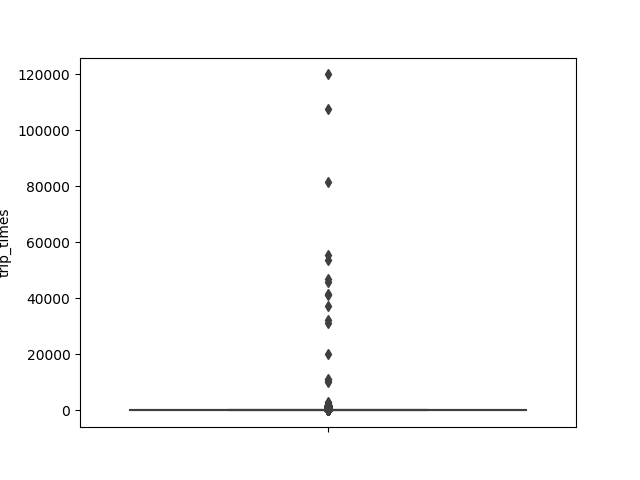

In [26]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [27]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,np.round(var[int(len(var)*(float(i)/100))],decimals=3)))
print ("100 percentile value is ",var[-1])

0 percentile value is -43.95
10 percentile value is 3.933
20 percentile value is 5.567
30 percentile value is 7.1
40 percentile value is 8.683
50 percentile value is 10.467
60 percentile value is 12.55
70 percentile value is 15.2
80 percentile value is 18.933
90 percentile value is 25.517
100 percentile value is  119912.7


In [28]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

#### pdf of trip-times after removing the outliers

<IPython.core.display.Javascript object>


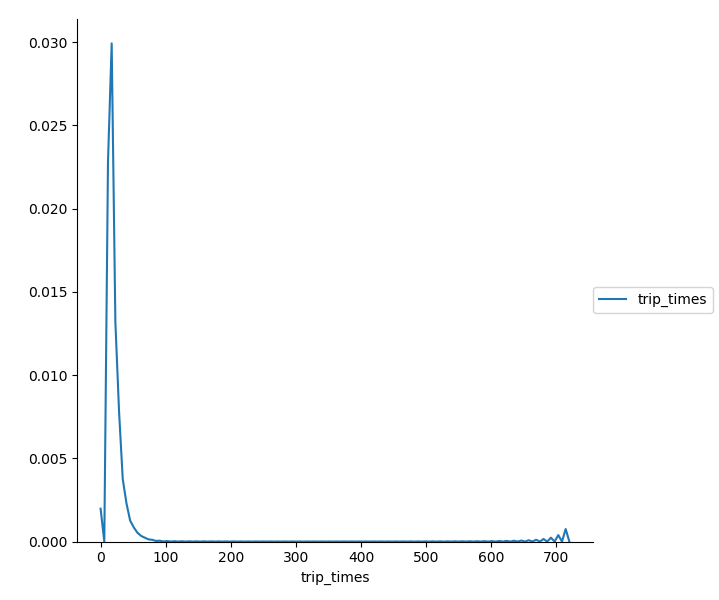

In [30]:

sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend()
plt.show()

In [31]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

<IPython.core.display.Javascript object>


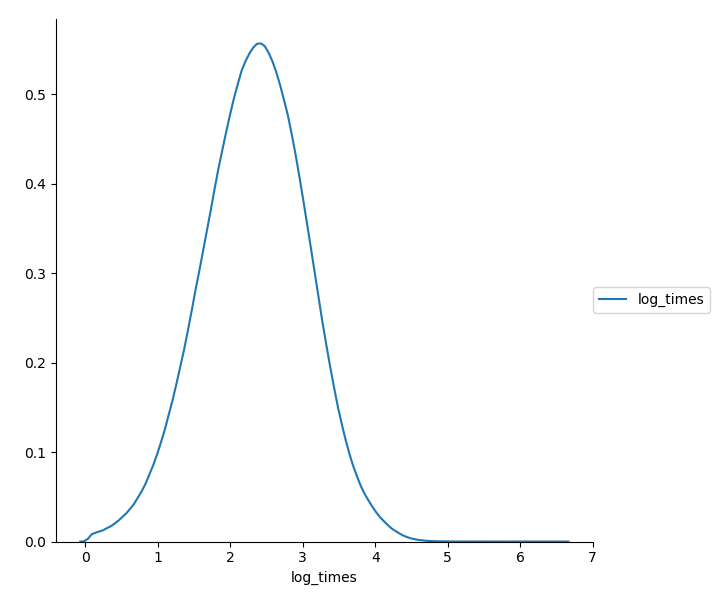

In [34]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend()
plt.show()

<IPython.core.display.Javascript object>


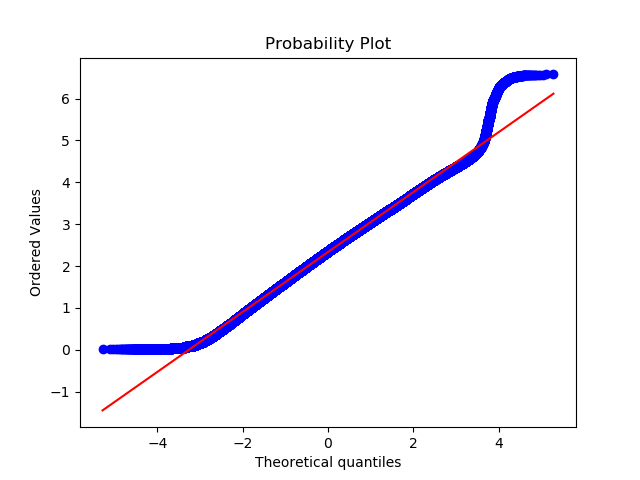

In [35]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

###  Speed

<IPython.core.display.Javascript object>


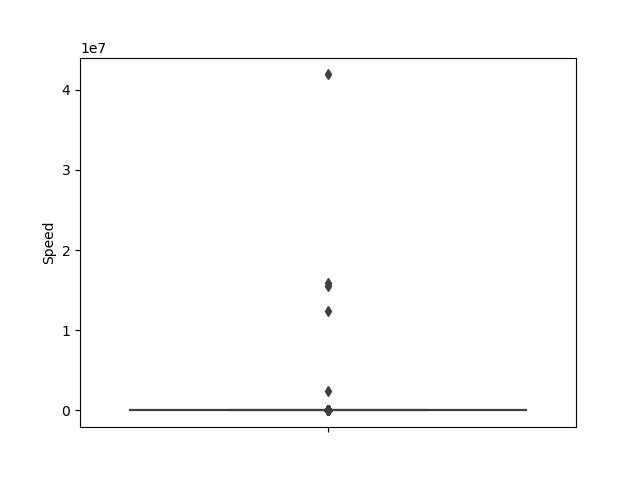

In [36]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [37]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.011787819253438
20 percentile value is 7.390029325513196
30 percentile value is 8.49689440993789
40 percentile value is 9.545454545454543
50 percentile value is 10.638522427440636
60 percentile value is 11.87948350071736
70 percentile value is 13.432835820895523
80 percentile value is 15.6734693877551
90 percentile value is 20.035906642728904
100 percentile value is  41917233.8028169


In [38]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.33428165007113
99.1 percentile value is 35.89123867069487
99.2 percentile value is 36.49769585253456
99.3 percentile value is 37.17507418397626
99.4 percentile value is 37.91878172588833
99.5 percentile value is 38.762376237623755
99.6 percentile value is 39.768642447418735
99.7 percentile value is 41.019230769230774
99.8 percentile value is 42.63212435233161
99.9 percentile value is 45.163636363636364
100 percentile value is  41917233.8028169


In [39]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

<b style='font-size:16px'>The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel <font color='blue'> 2 miles per 10min on avg.</font> </b>

### Trip Distance

<IPython.core.display.Javascript object>


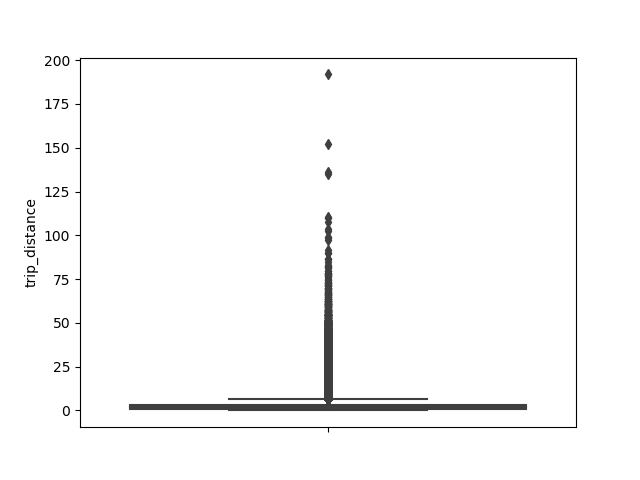

In [40]:
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [41]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.38
50 percentile value is 1.69
60 percentile value is 2.08
70 percentile value is 2.65
80 percentile value is 3.7
90 percentile value is 6.5
100 percentile value is  191.9


In [42]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.6
99.1 percentile value is 18.8
99.2 percentile value is 19.02
99.3 percentile value is 19.3
99.4 percentile value is 19.61
99.5 percentile value is 20.01
99.6 percentile value is 20.5
99.7 percentile value is 21.01
99.8 percentile value is 21.79
99.9 percentile value is 23.9
100 percentile value is  191.9


In [43]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

###  Total Fare

<IPython.core.display.Javascript object>


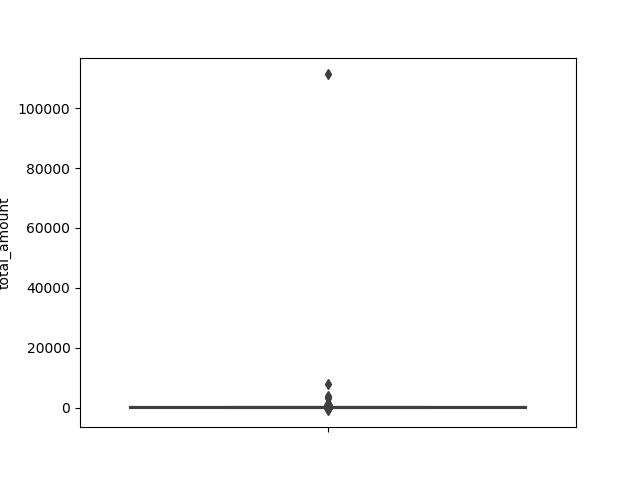

In [44]:
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [45]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -958.4
10 percentile value is 6.8
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 10.3
50 percentile value is 11.62
60 percentile value is 13.3
70 percentile value is 15.36
80 percentile value is 19.24
90 percentile value is 27.96
100 percentile value is  111271.65


In [47]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 69.99
99.1 percentile value is 69.99
99.2 percentile value is 70.01
99.3 percentile value is 70.01
99.4 percentile value is 70.01
99.5 percentile value is 70.01
99.6 percentile value is 72.89
99.7 percentile value is 72.92
99.8 percentile value is 78.34
99.9 percentile value is 92.76
100 percentile value is  111271.65


<IPython.core.display.Javascript object>


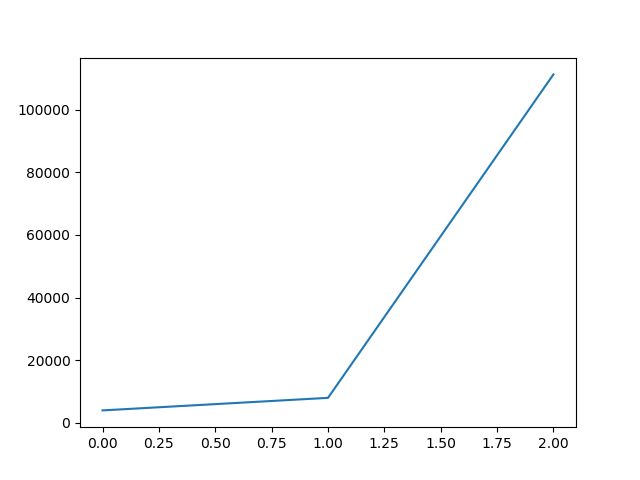

In [49]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

<IPython.core.display.Javascript object>


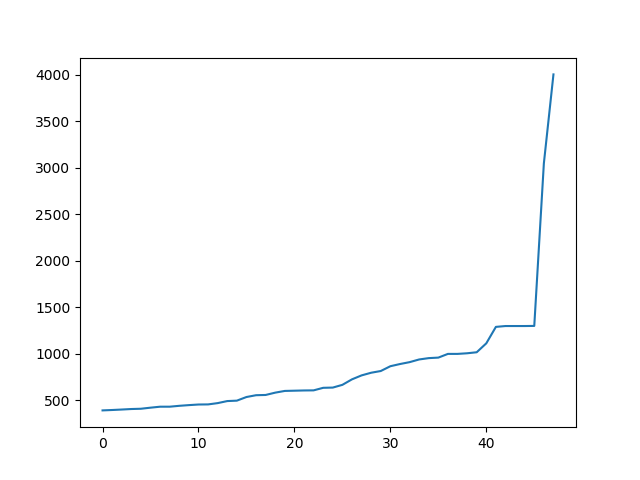

In [50]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

## Removing all outliers/erronous points.

In [51]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [52]:
print ("Removing outliers in the month of Jan-2016")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2016
----
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
fraction of data points that remain after removing outliers 0.9726975449758308


# Data-preperation
## Clustering/Segmentation

In [53]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# choosing number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  0.9866648594954689 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance =  0.6152041657282724 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 23.0 
Min inter-cluster distance =  0.5463175334037291 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 31.0 
Min inter-cluster distance 

In [54]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 40 clusters for solve the further problem

# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

### Plotting the cluster centers:

In [55]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

### Plotting the clusters:

<IPython.core.display.Javascript object>


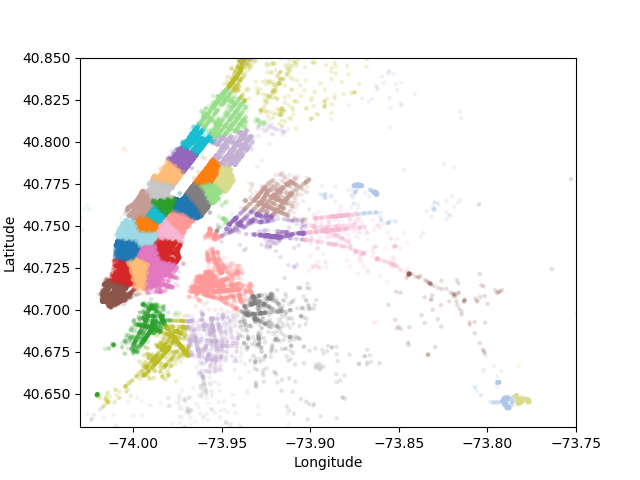

In [56]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

## Time-binning

In [57]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # (int((i-start_pickup_unix)/600)+33) : unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [59]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2016_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2016)
jan_2016_groupby = jan_2016_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [82]:
# hear the trip_distance represents the number of pickups that are happend in that particular 10min intravel
jan_2016_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                      183
               2                      265
               3                      288
               4                      248
               5                      210

In [83]:
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers from trip times analysis: 30868
Number of outliers from trip distance analysis: 87318
Number of outliers from speed analysis: 23889
Number of outliers from fare analysis: 5859
Total outliers removed 324635
---
Estimating clusters..
Final groupbying..


## smoothing

In [87]:
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [89]:
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

regions_cum = []
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])


In [250]:
import pickle as pkl
with open("total_set_data.pkl",'wb') as f:
    pkl.dump([regions_cum],f)

### Analysis on Time Series Data

Below is the time series for cluster 1


<IPython.core.display.Javascript object>


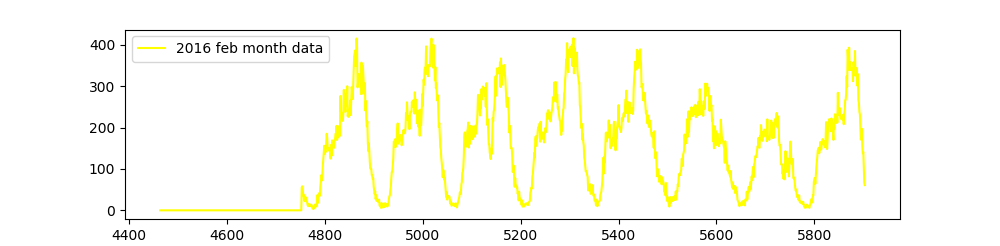

Below is the time series for cluster 2


<IPython.core.display.Javascript object>


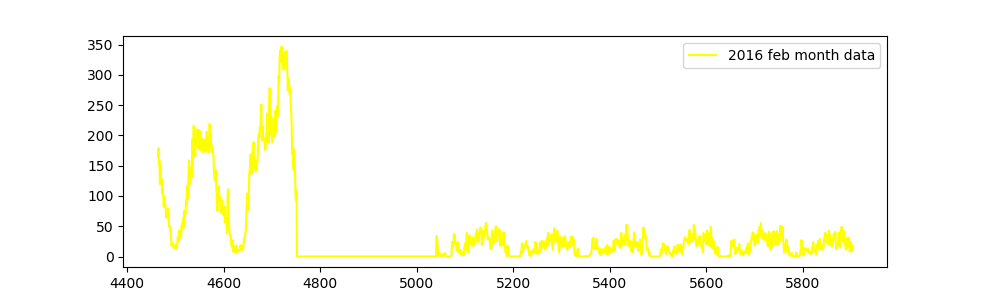

In [1777]:
second_x = list(range(4464,4464 +10*144 ))
for i in range(1,3):
    print("Below is the time series for cluster",i)
    plt.figure(figsize=(10,4))
    plt.plot(second_x,regions_cum[i][4464:4464 +10*144], color='yellow', label='2016 feb month data')
    plt.legend()
    plt.show()

observation:
  * Number of pickups in cluster 1 has increased drastically when the number of pickups in cluster 2 are almost zero.
      - This observation motivated me to calculate "Relative_demand" features.

## Fourier transform of the time series

<IPython.core.display.Javascript object>


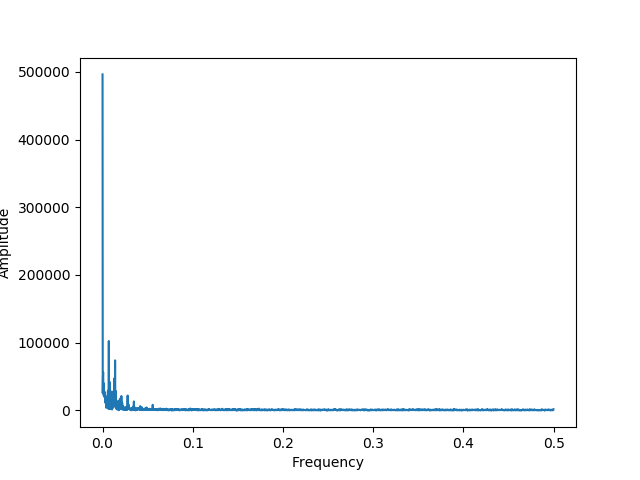

In [158]:
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

observation:
    * There are some frequencies with higher amplitude.

# Temporal Train - Test split 

In [1520]:
dataset_array = np.array(regions_cum)

In [1521]:
train_waves = dataset_array[:,:int(dataset_array.shape[1]*0.7)]
test_waves = dataset_array[:,int(dataset_array.shape[1]*0.7):]

# Extracting Feautres for Train Data

In [1522]:
dataframe_list =[] # every element in this list will represent a row. 

for i in range(train_waves.shape[0]):  # i represents a  cluster
    for j in range(train_waves.shape[1]-145):  # j to j+144 has the taxi demand for the LAST 24 hrs.
        
        row_list=[] # represents a row in the data frame.
        
        # calculating FFT on top of last 24 hours demand at cluster i
        Y=np.fft.fft(np.array(train_waves[i])[j:j+144])
        freq = np.fft.fftfreq(144, 1)
        Y_mag = np.abs(Y)
        Y_mag_half = Y_mag[0:int(Y_mag.shape[0]/2)]
        freq_half = freq[0:int(Y_mag.shape[0]/2)]
        
        # lists to extract top 4 important frequences, amplitudes
        frequency_list =[]
        amplitude_list =[]
        for mag in range(4) :
            
            index = np.argmax(Y_mag_half)        
            max_freq  = freq_half[index]
            max_amplitude = Y_mag_half[index]
            Y_mag_half[index]=0
            amplitude_list.append(max_amplitude)
            frequency_list.append(max_freq)
         
        # list to extract last five time intervals demand.
        previous_5_timestamps_demand =[]
        previous_5_timestamps_demand.append(np.array(train_waves[i])[j+144+0])
        previous_5_timestamps_demand.append(np.array(train_waves[i])[j+144-1])
        previous_5_timestamps_demand.append(np.array(train_waves[i])[j+144-2])
        previous_5_timestamps_demand.append(np.array(train_waves[i])[j+144-3])
        previous_5_timestamps_demand.append(np.array(train_waves[i])[j+144-4])
        
        
        # this below code will extract the relative demand  in the last 5 time intervals
        summ  =0
        for z in range(40): #z again represents cluster (location)
            summ = summ + np.array(train_waves[z])[j+144+0]
        
        relative_demand_1 = np.array(train_waves[i])[j+144+0]/summ
        
        summ =0
        for z in range(40):
            summ = summ + np.array(train_waves[z])[j+144-1]
        
        relative_demand_2 = np.array(train_waves[i])[j+144-1]/summ
        
        summ =0
        for z in range(40):
            summ = summ + np.array(train_waves[z])[j+144-2]
        
        relative_demand_3 = np.array(train_waves[i])[j+144-2]/summ
        
        summ =0
        for z in range(40):
            summ = summ + np.array(train_waves[z])[j+144-3]
        
        relative_demand_4 = np.array(train_waves[i])[j+144-3]/summ
        
        summ =0
        for z in range(40):
            summ = summ + np.array(train_waves[z])[j+144-4]
        
        relative_demand_5 = np.array(train_waves[i])[j+144-4]/summ
        
        #this will be class label
        taxi_deamand_in_next_10_min = np.array(train_waves[i])[j+144+1]
        
        
        #adding all the extracted features to the row list
        row_list.extend(frequency_list)
        row_list.extend(amplitude_list)
        row_list.extend(previous_5_timestamps_demand)
        row_list.append(relative_demand_1)
        row_list.append(relative_demand_2)
        row_list.append(relative_demand_3)
        row_list.append(relative_demand_4)
        row_list.append(relative_demand_5)
        row_list.extend(cluster_centers[i]) # latitude and longitude of the cluster.
        row_list.append(taxi_deamand_in_next_10_min)
        
        #add row to the dataframe list
        dataframe_list.append(row_list)

In [1523]:
train_df = pd.DataFrame(dataframe_list,columns=['freq_'+str(x) for x in range(4)]+['amplitude_'+str(x) for x in range(4)]+['previous_demand'+str(x) for x in range(5)]+['relative_demand'+str(x) for x in range(5) ]+['latitude','longitude']+['y_actual'])
train_df.head(2)

,freq_0,freq_1,freq_2,freq_3,amplitude_0,amplitude_1,amplitude_2,amplitude_3,previous_demand0,previous_demand1,...,previous_demand3,previous_demand4,relative_demand0,relative_demand1,relative_demand2,relative_demand3,relative_demand4,latitude,longitude,y_actual
0,0.0,0.006944,0.013889,0.041667,14487.0,3638.206318,2069.361083,810.857059,159,132,...,148,139,0.073204,0.061711,0.053201,0.071775,0.070774,40.736079,-74.003358,155
1,0.0,0.006944,0.013889,0.034722,14646.0,3778.976039,2158.898393,946.815932,155,159,...,118,148,0.080145,0.073204,0.061711,0.053201,0.071775,40.736079,-74.003358,156


### Extracting Exponential Weighted Moving Averages for the train data.

In [1524]:
def EA_P1_Predictions(ratios):
    predicted_value= (ratios['y_actual'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,9027*40):
        if i%9027==0: 
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['y_actual'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['y_actual'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['y_actual'].values)/len(ratios['y_actual'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [1525]:
a,b,c = EA_P1_Predictions(train_df)

In [1526]:
train_df.head(2)

,freq_0,freq_1,freq_2,freq_3,amplitude_0,amplitude_1,amplitude_2,amplitude_3,previous_demand0,previous_demand1,...,relative_demand0,relative_demand1,relative_demand2,relative_demand3,relative_demand4,latitude,longitude,y_actual,EA_P1_Predicted,EA_P1_Error
0,0.0,0.006944,0.013889,0.041667,14487.0,3638.206318,2069.361083,810.857059,159,132,...,0.073204,0.061711,0.053201,0.071775,0.070774,40.736079,-74.003358,155,0,0.0
1,0.0,0.006944,0.013889,0.034722,14646.0,3778.976039,2158.898393,946.815932,155,159,...,0.080145,0.073204,0.061711,0.053201,0.071775,40.736079,-74.003358,156,155,1.0


# Extracting features for test data

In [1527]:
test_waves = dataset_array[:,int(dataset_array.shape[1]*0.7) - 144:] 

#re arranging test dataframe.

# every data point will be calculated using the LAST 24hrs demand, hence this doesn't leak the data.

In [1528]:
test_dataframe_list =[]

for i in range(test_waves.shape[0]): # i represents a  cluster
    for j in range(test_waves.shape[1]-145):  # j to j+144 has the taxi demand for the LAST 24 hrs.
        row_list=[]
        
        Y=np.fft.fft(np.array(test_waves[i])[j:j+144])
        freq = np.fft.fftfreq(144, 1)
        Y_mag = np.abs(Y)
        Y_mag_half = Y_mag[0:int(Y_mag.shape[0]/2)]
        freq_half = freq[0:int(Y_mag.shape[0]/2)]
        frequency_list =[]
        amplitude_list =[]
        for mag in range(4) :
            
            index = np.argmax(Y_mag_half)        
            max_freq  = freq_half[index]
            max_amplitude = Y_mag_half[index]
            Y_mag_half[index]=0
            amplitude_list.append(max_amplitude)
            frequency_list.append(max_freq)
            
        previous_5_timestamps_demand =[]
        previous_5_timestamps_demand.append(np.array(test_waves[i])[j+144+0])
        previous_5_timestamps_demand.append(np.array(test_waves[i])[j+144-1])
        previous_5_timestamps_demand.append(np.array(test_waves[i])[j+144-2])
        previous_5_timestamps_demand.append(np.array(test_waves[i])[j+144-3])
        previous_5_timestamps_demand.append(np.array(test_waves[i])[j+144-4])
        
        summ =0
        for z in range(40):
            summ = summ + np.array(test_waves[z])[j+144+0]
        relative_demand_1 = np.array(test_waves[i])[j+144+0]/summ
        
        
        summ =0
        for z in range(40):
            summ = summ + np.array(test_waves[z])[j+144-1]
        relative_demand_2 = np.array(test_waves[i])[j+144-1]/summ
        
        
        summ =0
        for z in range(40):
            summ = summ + np.array(test_waves[z])[j+144-2]
        relative_demand_3 = np.array(test_waves[i])[j+144-2]/summ
        
        
        summ =0
        for z in range(40):
            summ = summ + np.array(test_waves[z])[j+144-3]
        relative_demand_4 = np.array(test_waves[i])[j+144-3]/summ
        
        
        summ =0
        for z in range(40):
            summ = summ + np.array(test_waves[z])[j+144-4]
        
        relative_demand_5 = np.array(test_waves[i])[j+144-4]/summ
        
        
        taxi_deamand_in_next_10_min = np.array(test_waves[i])[j+144+1]
        row_list.extend(frequency_list)
        row_list.extend(amplitude_list)
        row_list.extend(previous_5_timestamps_demand)
        row_list.append(relative_demand_1)
        row_list.append(relative_demand_2)
        row_list.append(relative_demand_3)
        row_list.append(relative_demand_4)
        row_list.append(relative_demand_5)
        row_list.extend(cluster_centers[i])
        row_list.append(taxi_deamand_in_next_10_min)
        test_dataframe_list.append(row_list)

In [1529]:
test_df = pd.DataFrame(test_dataframe_list,columns=['freq_'+str(x) for x in range(4)]+['amplitude_'+str(x) for x in range(4)]+['previous_demand'+str(x) for x in range(5)]+ ['relative_demand'+str(x) for x in range(5) ]+['latitude','longitude']+['y_actual'])
test_df.head(2)

,freq_0,freq_1,freq_2,freq_3,amplitude_0,amplitude_1,amplitude_2,amplitude_3,previous_demand0,previous_demand1,...,previous_demand3,previous_demand4,relative_demand0,relative_demand1,relative_demand2,relative_demand3,relative_demand4,latitude,longitude,y_actual
0,0.0,0.013889,0.006944,0.020833,18763.0,3975.279802,3770.732165,1256.060226,84,100,...,101,90,0.030758,0.036417,0.034939,0.033745,0.029791,40.736079,-74.003358,88
1,0.0,0.013889,0.006944,0.020833,18761.0,3977.145393,3769.679581,1254.159034,88,84,...,95,101,0.031575,0.030758,0.036417,0.034939,0.033745,40.736079,-74.003358,101


### Extracting Exponential Weighted Moving Averages for the test data.

In [1530]:
def EA_P1_Predictions_test(ratios):
    predicted_value= (ratios['y_actual'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,3931*40):
        if i%3931==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['y_actual'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['y_actual'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['y_actual'].values)/len(ratios['y_actual'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [1531]:
d,e,f = EA_P1_Predictions_test(test_df)

In [1532]:
test_df.head(3)

,freq_0,freq_1,freq_2,freq_3,amplitude_0,amplitude_1,amplitude_2,amplitude_3,previous_demand0,previous_demand1,...,relative_demand0,relative_demand1,relative_demand2,relative_demand3,relative_demand4,latitude,longitude,y_actual,EA_P1_Predicted,EA_P1_Error
0,0.0,0.013889,0.006944,0.020833,18763.0,3975.279802,3770.732165,1256.060226,84,100,...,0.030758,0.036417,0.034939,0.033745,0.029791,40.736079,-74.003358,88,0,0.0
1,0.0,0.013889,0.006944,0.020833,18761.0,3977.145393,3769.679581,1254.159034,88,84,...,0.031575,0.030758,0.036417,0.034939,0.033745,40.736079,-74.003358,101,88,13.0
2,0.0,0.013889,0.006944,0.020833,18756.0,3981.635374,3766.868376,1249.651715,101,88,...,0.032539,0.031575,0.030758,0.036417,0.034939,40.736079,-74.003358,115,97,18.0


In [1535]:
train_df.to_csv("taxi_train_data.csv",index=False)
test_df.to_csv("taxi_test_data.csv",index=False)

del test_dataframe_list
del dataframe_list

# Modeling

### Pre Processing

In [1567]:
train_df =pd.read_csv('taxi_train_data.csv')
test_df =pd.read_csv('taxi_test_data.csv')

In [1568]:
### dropping columns which are not features 

train_df = train_df.drop(['EA_P1_Error'],axis=1)
test_df = test_df.drop(['EA_P1_Error'],axis=1)
train_df = train_df.drop(['freq_0'],axis=1)
test_df = test_df.drop(['freq_0'],axis=1)
train_df = train_df.drop([0],axis=0)
test_df = test_df.drop([0],axis=0)
train_score = train_df['y_actual'].values 
test_score = test_df['y_actual'].values
train_df = train_df.drop(['y_actual'],axis=1)
test_df = test_df.drop(['y_actual'],axis=1)

In [1569]:
# imputing
train_df['relative_demand0'].fillna(train_df['relative_demand0'].mean(), inplace=True)
train_df['relative_demand1'].fillna(train_df['relative_demand1'].mean(), inplace=True)
train_df['relative_demand2'].fillna(train_df['relative_demand2'].mean(), inplace=True)
train_df['relative_demand3'].fillna(train_df['relative_demand3'].mean(), inplace=True)
train_df['relative_demand4'].fillna(train_df['relative_demand4'].mean(), inplace=True)

In [1570]:
train_features = train_df.values
test_features = test_df.values

## SGD Regressor

In [1679]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

In [1704]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor

tuned_parameters = [{'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                    'learning_rate': ['constant','optimal','invscaling','adaptive']}]

# scoring = neg_mean_absolute_error, as the mean absolute error is directly proportional to mean absolute percentage error. 

model = GridSearchCV(SGDRegressor(random_state =45), tuned_parameters, scoring = 'neg_mean_absolute_error', cv=5,n_jobs=-1, return_train_score=True)

model.fit(scaled_train_features,train_score)

print(model.best_estimator_)

y_pred = model.best_estimator_.predict(scaled_test_features)
test_predictions = [round(value) for value in y_pred]
y_pred = model.best_estimator_.predict(scaled_train_features)
train_predictions = [round(value) for value in y_pred]

err = mean_absolute_error(train_score,train_predictions)/(sum(train_score)/len(train_score))
print("\n\nTrain data MAPE :",err)

err = mean_absolute_error(test_score,test_predictions)/(sum(test_score)/len(test_score))
print("\nTest data MAPE :",err)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='epsilon_insensitive', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=45, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)


Train data MAPE : 0.13340938967999338

Test data MAPE : 0.12795269064142212


## Linear Regression

In [1705]:
from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(scaled_train_features, train_score)
y_pred = lr_reg.predict(scaled_test_features)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(scaled_train_features)
lr_train_predictions = [round(value) for value in y_pred]


err = mean_absolute_error(train_score,lr_train_predictions)/(sum(train_score)/len(train_score))
print('Train data MAPE :',err)

err = mean_absolute_error(test_score,lr_test_predictions)/(sum(test_score)/len(test_score))
print('Test data MAPE  :',err)

Train data MAPE : 0.13236681712462883
Test data MAPE  : 0.12688268081269535


## Random Forest Decision Trees Regressor

In [1709]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'n_estimators': list(range(20,71,10))}]

model = GridSearchCV(RandomForestRegressor(), tuned_parameters, scoring = 'neg_mean_absolute_error', cv=3,n_jobs=-1, return_train_score=True)
model.fit(scaled_train_features,train_score)

print(model.best_estimator_)

y_pred = model.best_estimator_.predict(scaled_test_features)
test_predictions = [round(value) for value in y_pred]
y_pred = model.best_estimator_.predict(scaled_train_features)
train_predictions = [round(value) for value in y_pred]

err = mean_absolute_error(train_score,train_predictions)/(sum(train_score)/len(train_score))
print("\n\nTrain data MAPE :",err)

err = mean_absolute_error(test_score,test_predictions)/(sum(test_score)/len(test_score))
print("\nTest data MAPE :",err)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


Train data MAPE : 0.0461892920508554

Test data MAPE : 0.12013490206959335


<IPython.core.display.Javascript object>


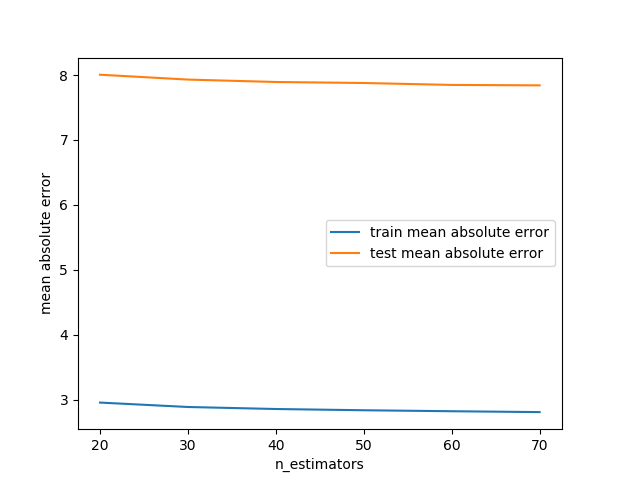

In [1711]:
cv_scores = pd.DataFrame(model.cv_results_)
cv_scores = cv_scores.sort_values(by =['param_n_estimators'])
plt.plot(cv_scores['param_n_estimators'],-cv_scores['mean_train_score'],label='train mean absolute error')
plt.plot(cv_scores['param_n_estimators'],-cv_scores['mean_test_score'],label='test mean absolute error')
plt.xlabel('n_estimators')
plt.ylabel('mean absolute error')
plt.legend()
plt.show()

## XGBoost Regressor

In [1724]:
tuned_parameters={
    'max_depth' : [2,3,4],
    'n_estimators': [25,50,100,200],
    'learning_rate':[0.1],
    'booster':['gbtree'],
    'n_jobs':[-1],
}

xgb_model = xgb.XGBRegressor()
model = GridSearchCV(xgb_model, tuned_parameters, scoring = 'neg_mean_absolute_error', cv=5,n_jobs=1,return_train_score =True)
model.fit(scaled_train_features,train_score)

print(model.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [1726]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4)

x_model.fit(scaled_train_features, train_score)


y_pred = x_model.predict(scaled_test_features)
test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(scaled_train_features)
train_predictions = [round(value) for value in y_pred]

err = mean_absolute_error(train_score,train_predictions)/(sum(train_score)/len(train_score))
print("\n\nTrain data MAPE :",err)

err = mean_absolute_error(test_score,test_predictions)/(sum(test_score)/len(test_score))
print("\nTest data MAPE :",err)



Train data MAPE : 0.11785978911370762

Test data MAPE : 0.11879918125473485


# Feature Importance

<IPython.core.display.Javascript object>


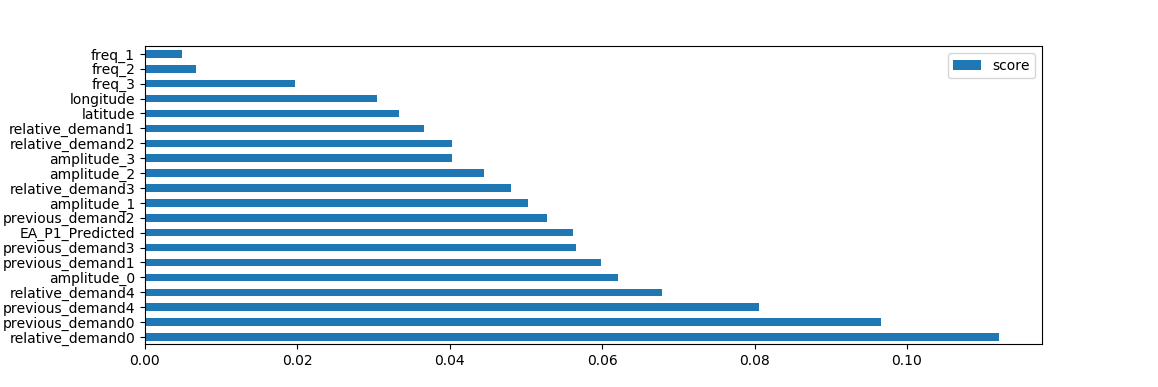

In [1772]:
feature_important = x_model.feature_importances_
keys = list(train_df.columns)
values = list(feature_important)

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')
plt.show()

# Conclusion

In [1745]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names=['Model','Hyper parameters','Train MAPE','Test MAPE']
x.add_row(['SGD Regressor','loss = epsilon_insensitive\nlearning_rate= optimal\n','13.34%','12.79%'])
x.add_row(['Linear Regression\n',' -- ','13.23%','12.68%'])
x.add_row(['Random Forest Decision Trees Regressor\n','n_estimators = 70','4.61%','12.01%'])
x.add_row(['XGBoost Regressor\n','learning_rate = 0.1\nn_estimators = 1000\nmax_depth = 4','11.78%','11.87%'])


print(x)

+----------------------------------------+----------------------------+------------+-----------+
|                 Model                  |      Hyper parameters      | Train MAPE | Test MAPE |
+----------------------------------------+----------------------------+------------+-----------+
|             SGD Regressor              | loss = epsilon_insensitive |   13.34%   |   12.79%  |
|                                        |   learning_rate= optimal   |            |           |
|                                        |                            |            |           |
|           Linear Regression            |             --             |   13.23%   |   12.68%  |
|                                        |                            |            |           |
| Random Forest Decision Trees Regressor |     n_estimators = 70      |   4.61%    |   12.01%  |
|                                        |                            |            |           |
|           XGBoost Regressor 